# This is the Saildrone and HF Radar collocation code. 
- There is a 0.5 scale problem in the comparisons, which is pretty close to the conversion between knots to m/s and I'm worried that somewhere there is a problem with the ADCP data


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import xarray as xr


# Read in USV data
Read in the Saildrone USV file either from a local disc or using OpenDAP.

There are 6 NaN values in the lat/lon data arrays, interpolate across these

We want to collocate with wind vectors for this example,  but the wind vectors are only every 10 minutes rather than every minute, so use .dropna to remove all values in the dataset from all dataarrays when wind vectors aren't availalbe

In [4]:
filename_usv='https://podaac-opendap.jpl.nasa.gov/opendap/allData/insitu/L2/saildrone/Baja/saildrone-gen_4-baja_2018-sd1002-adcp-20180411T175730-20180611T235730_300s-v1.nc'
ds_usv = xr.open_dataset(filename_usv)
ds_usv = ds_usv.swap_dims({'cell':'cell_depth'})
ds_usv = ds_usv.isel(cell_depth=0)
ds_usv = ds_usv.isel(trajectory=0).drop('trajectory')
ds_usv = ds_usv.swap_dims({'obs':'time'})
ds_usv = ds_usv.rename({'longitude':'lon','latitude':'lat'})
ds_usv = ds_usv.sel(time=slice('2018-04-11T18:30','2018-06-10T18:00'))  #first part of data is when USV being towed, elminiate
ds_usv2 = ds_usv.copy(deep=True)
ds_usv_subset = ds_usv.copy(deep=True)
ds_usv_subset2 = ds_usv2.copy(deep=True)
ds_usv_subset['spd']=np.sqrt(ds_usv_subset.vel_east**2+ds_usv_subset.vel_north**2)
ds_usv_subset['dir']=np.arctan2(ds_usv_subset.vel_north,ds_usv_subset.vel_east)*180/np.pi
ds_usv_subset['ship_spd']=np.sqrt(ds_usv_subset.ship_vel_east**2+ds_usv_subset.ship_vel_north**2)
ds_usv_subset['ship_dir']=np.arctan2(ds_usv_subset.ship_vel_north,ds_usv_subset.ship_vel_east)*180/np.pi
ds_usv_subset


<xarray.Dataset>
Dimensions:              (beam: 4, time: 8603)
Coordinates:
    cell_depth           float32 4.2
  * time                 (time) datetime64[ns] 2018-04-11T19:50:00 ... 2018-06-10T18:00:00
Dimensions without coordinates: beam
Data variables:
    lat                  (time) float64 37.77 37.76 37.76 ... 37.63 37.63 37.64
    lon                  (time) float64 -122.6 -122.6 -122.6 ... -122.8 -122.8
    roll                 (time) float64 4.82 10.47 -12.32 ... 2.01 9.76 7.43
    pitch                (time) float64 1.77 -0.24 1.66 0.9 ... 0.35 0.25 0.69
    heading              (time) float64 286.0 278.7 184.0 ... 23.99 23.85 30.12
    nav_end_latitude     (time) float64 37.76 37.76 37.76 ... 37.63 37.64 37.64
    nav_end_longitude    (time) float64 -122.6 -122.6 -122.6 ... -122.8 -122.8
    nav_end_time         (time) datetime64[ns] 2018-04-11T19:52:29.232002304 ... 2018-06-10T18:02:29.608001792
    nav_start_latitude   (time) float64 37.77 37.76 37.76 ... 37.63 37.63 37.

In [5]:
ds_usv.vel_east.attrs['units']  #just to show it says ms-1 as units

'ms-1'

# Read in HFradar data




In [31]:
#hf_filename = 'http://hfrnet-tds.ucsd.edu/thredds/dodsC/HFR/USWC/2km/hourly/RTV/HFRADAR_US_West_Coast_2km_Resolution_Hourly_RTV_best.ncd'
hf_filename = 'http://hfrnet-tds.ucsd.edu/thredds/dodsC/HFR/USWC/6km/hourly/RTV/HFRADAR_US_West_Coast_6km_Resolution_Hourly_RTV_best.ncd'
ds_sat = xr.open_dataset(hf_filename)
subset = ds_sat.sel(lon=slice(ds_usv_subset.lon.min().data,ds_usv_subset.lon.max().data),
                    lat=slice(ds_usv_subset.lat.min().data,ds_usv_subset.lat.max().data),
                   time=slice(ds_usv_subset.time.min().data,ds_usv_subset.time.max().data))
subset.load()  #this loads data into memory instead of leaving it lazy.  the hf radar opendap need this for some reason
subset['spd']=np.sqrt(subset.u**2+subset.v**2)
subset['dir']=np.arctan2(subset.v,subset.u)*180/np.pi
#print(subset.u) #just print out to show it also says ms-1
print(subset.u.attrs['units'])

m s-1


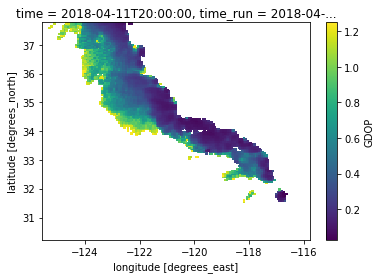

In [32]:
#according to HF radar documentation GDOP is a measure of accuracy for HF radar vectors, but I didn't really see any 
#big changes when using it, here it is plotted but not used
subset['GDOP']=np.sqrt(subset.DOPx**2+subset.DOPy**2)
subset.DOPx.comment
subset.GDOP[0,:,:].plot()

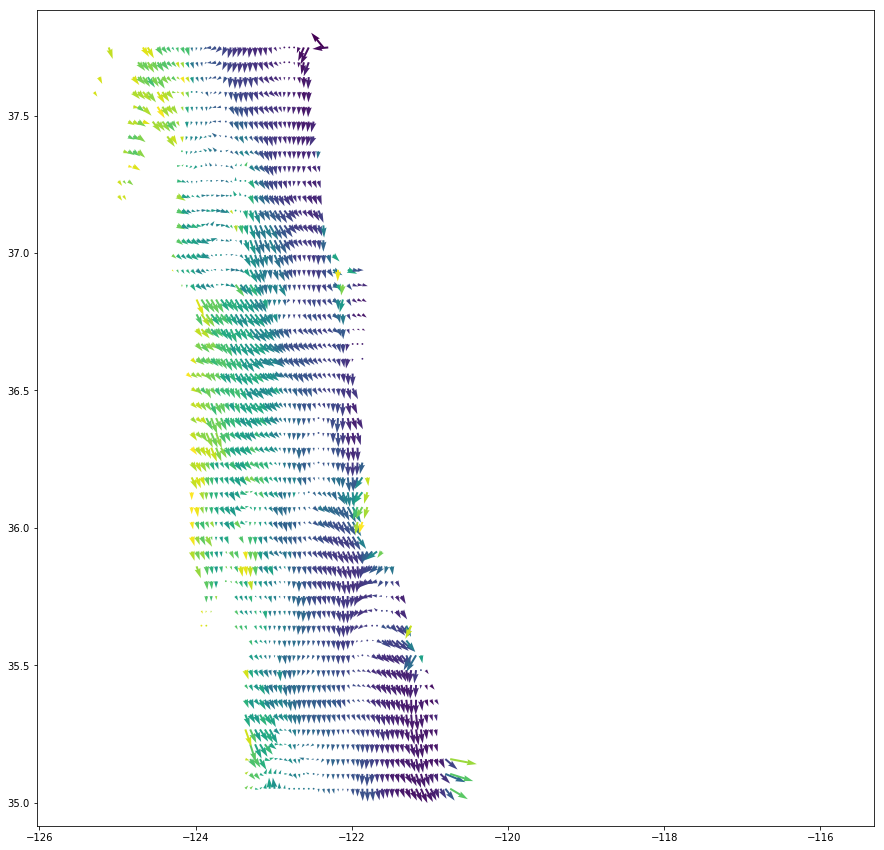

In [33]:
subset2 = subset.sel(lat=slice(35,38))
plt.figure(num=None, figsize=(15,15)) 
plt.quiver(subset2.lon,
           subset2.lat,subset2.u[0,:,:],
           subset2.v[0,:,:],
           subset2.GDOP[0,:,:],
           scale=2, 
           scale_units='inches')

## Plot the USV track on the HF radar data to show where the matchups occur

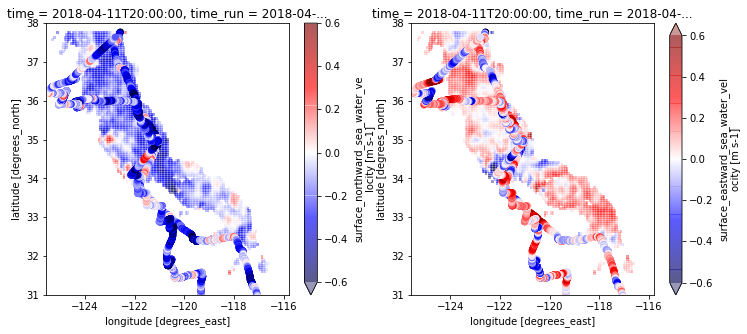

In [34]:
#Most of the cruise is near the coast, in a region where data
#is supposed to be good
f, axes = plt.subplots(1,2,figsize=(12,5))

subset.v[0,:,:].plot(ax=axes[0],cmap='seismic',vmin=-.6,vmax=.6,alpha=.4)
axes[0].scatter(ds_usv_subset.lon,ds_usv_subset.lat,c=ds_usv_subset.vel_north,cmap='seismic',vmin=-.6,vmax=.6)
axes[0].set_ylim(31,38)

subset.u[0,:,:].plot(ax=axes[1],cmap='seismic',vmin=-.6,vmax=.6,alpha=.4)
axes[1].scatter(ds_usv_subset.lon,ds_usv_subset.lat,c=ds_usv_subset.vel_east,cmap='seismic',vmin=-.6,vmax=.6)
axes[1].set_ylim(31,38)

fig_fname='F:/data/cruise_data/saildrone/baja-2018/figs/hf_radar_coverage.png'
plt.savefig(fig_fname, transparent=False, format='png')

# Now collocate the HF radar data with the USV Saildrone data 
- interpolate HF data onto usv trajectory using interp

In [35]:
#now collocate with usv lat and lons
ds_collocated = subset.interp(lat=ds_usv_subset.lat,lon=ds_usv_subset.lon,time=ds_usv_subset.time,method='linear')
ds_collocated_nearest = subset.interp(lat=ds_usv_subset.lat,lon=ds_usv_subset.lon,time=ds_usv_subset.time,method='nearest')

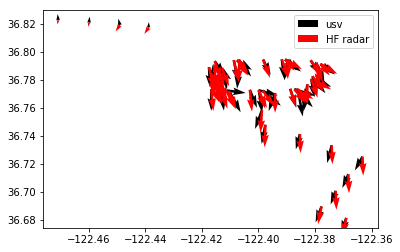

In [39]:
usv1 = ds_usv_subset.sel(time=slice('2018-04-12T19','2018-04-13T08'))
hf1 = ds_collocated_nearest.sel(time=slice('2018-04-12T19','2018-04-13T08'))
#print(usv1.lat)
ax1=plt.subplot(1,1,1)
ax1.quiver(usv1.lon,usv1.lat,usv1.vel_east,usv1.vel_north)
#ax1.quiver(usv1.lon,usv1.lat,usv1.UWND_MEAN,usv1.VWND_MEAN,color='b')
ax1.quiver(hf1.lon,hf1.lat,hf1.u,hf1.v,color='r')
plt.legend(['usv','HF radar'])
fig_fname='F:/data/cruise_data/saildrone/baja-2018/figs/hf_radar_tseries_412both_bias.png'
plt.savefig(fig_fname, transparent=False, format='png')


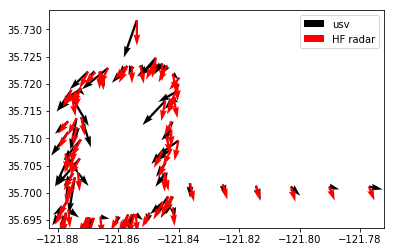

In [40]:
usv1 = ds_usv_subset.sel(time=slice('2018-04-14T02','2018-04-14T14'))
hf1 = ds_collocated_nearest.sel(time=slice('2018-04-14T02','2018-04-14T14'))
#print(usv1.lat)
ax1=plt.subplot(1,1,1)
ax1.quiver(usv1.lon,usv1.lat,usv1.vel_east,usv1.vel_north)
#ax1.quiver(usv1.lon,usv1.lat,usv1.UWND_MEAN,usv1.VWND_MEAN,color='b')
ax1.quiver(hf1.lon,hf1.lat,hf1.u,hf1.v,color='r')
plt.legend(['usv','HF radar'])
fig_fname='F:/data/cruise_data/saildrone/baja-2018/figs/hf_radar_tseries_414both_bias.png'
plt.savefig(fig_fname, transparent=False, format='png')


In [13]:
#usv1['wspd']=np.sqrt(usv1.UWND_MEAN**2+usv1.VWND_MEAN**2)
#plt.plot(usv1.wspd,usv1.spd-hf1.spd,'.')
#plt.plot(usv1.time,usv1.wspd)

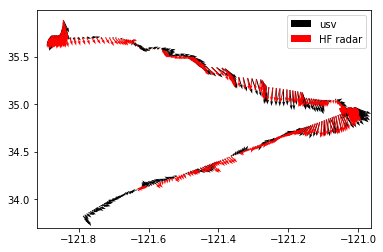

In [41]:
usv1 = ds_usv_subset.sel(time=slice('2018-04-14','2018-04-16'))
hf1 = ds_collocated_nearest.sel(time=slice('2018-04-14','2018-04-16'))
ax1=plt.subplot(1,1,1)
ax1.quiver(usv1.lon,usv1.lat,usv1.vel_east,usv1.vel_north)
ax1.quiver(hf1.lon,hf1.lat,hf1.u,hf1.v,color='r')
plt.legend(['usv','HF radar'])

fig_fname='F:/data/cruise_data/saildrone/baja-2018/figs/hf_radar_tseries_both_bias.png'
plt.savefig(fig_fname, transparent=False, format='png')


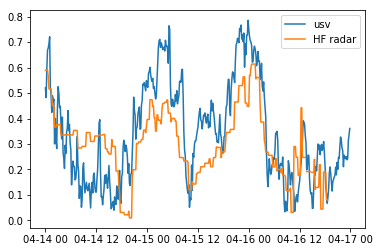

In [42]:
plt.plot(usv1.time,usv1.spd)
plt.plot(hf1.time,hf1.spd)
plt.legend(['usv','HF radar'])
fig_fname='F:/data/cruise_data/saildrone/baja-2018/figs/hf_radar_tseries2_both_bias.png'
plt.savefig(fig_fname, transparent=False, format='png')

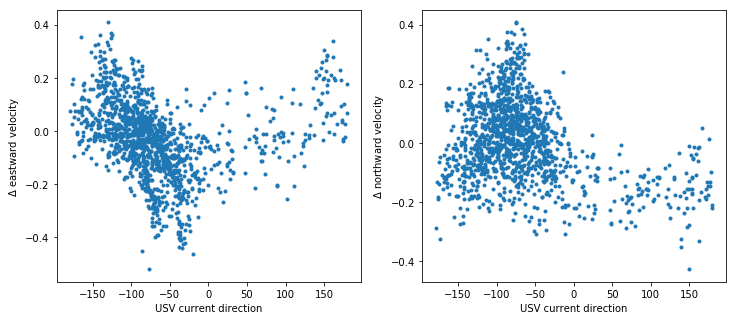

In [44]:
f, axes = plt.subplots(1,2,figsize=(12,5))
usv1 = ds_usv_subset.where(np.isfinite(ds_collocated.spd))
hf1 = ds_collocated_nearest.where(np.isfinite(ds_collocated.spd))
ax1=plt.subplot(1,2, 1)
ax1.plot(usv1.dir,hf1.u-usv1.vel_east,'.')
ax1.set_xlabel('USV current direction')
ax1.set_ylabel('$\Delta$ eastward velocity')
ax2=plt.subplot(1,2, 2)
ax2.plot(usv1.dir,hf1.v-usv1.vel_north,'.')
ax2.set_xlabel('USV current direction')
ax2.set_ylabel('$\Delta$ northward velocity')
fig_fname='F:/data/cruise_data/saildrone/baja-2018/figs/hf_radar_tseries_both_wdir2.png'
plt.savefig(fig_fname, transparent=False, format='png')

mean current diff speed all 0.03649815495096688
std current diff speed all 0.13177170157085225
mean diff last half 0.05233633081616556
std diff last half 0.13374092599990622
mean diff first half -0.006656874742339653
std diff first half 0.11572935155240083
2018-04-14T02:10:00.000000000


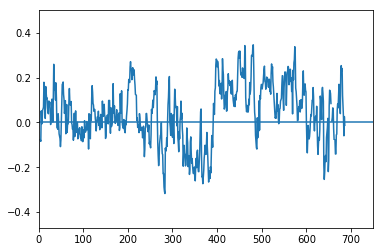

In [74]:
#2nd half of dataset seems much better
usv1 = ds_usv_subset.where(np.isfinite(ds_collocated_nearest.spd))
hf1 = ds_collocated_nearest.where(np.isfinite(ds_collocated_nearest.spd))
plt.axhline(0)
plt.plot(usv1.spd-hf1.spd)
#plt.plot((usv1.TEMP_CTD_MEAN-usv1.TEMP_CTD_MEAN.mean())/(4*usv1.TEMP_CTD_MEAN.std()))
#plt.plot(usv1.dir))
plt.xlim(0,750)
#plt.xlim(6900,7550)
print('mean current diff speed all',(usv1.spd-hf1.spd).mean().data)
print('std current diff speed all',(usv1.spd-hf1.spd).std().data)
print('mean diff last half',(usv1.spd[400:]-hf1.spd[400:]).mean().data)
print('std diff last half',(usv1.spd[400:]-hf1.spd[400:]).std().data)
print('mean diff first half',(usv1.spd[:400]-hf1.spd[:400]).mean().data)
print('std diff first half',(usv1.spd[:400]-hf1.spd[:400]).std().data)
print(usv1.time[300].data)
#results using collcoated file
#mean current speed 0.3211718392967916 0.2803949
#mean 0.05026234680304413
#std 0.15365239101244357
#mean 0.03216915862753498
#std 0.12825959509881765
#2018-04-14T02:10:00.000000000


# A larger STD that isn't reflective of uncertainty in the observation
The collocation above will result in multiple USV data points matched with a single satellite
observation.    The USV is sampling every 1 min and approximately few meters, while the satellite
is an average over a footprint that is interpolated onto a daily mean map.  While calculating the mean would results in a valid mean, the STD would be higher and consist of a component that reflects the uncertainty of the USV and the satellite and a component that reflects the natural variability in the region that is sampled by the USV

Below we use the 'nearest' collocation results to identify when multiple USV data are collcated to
a single satellite observation.
This code goes through the data and creates averages of the USV data that match the single CCMP collocated value.
This code isn't perfect, but I couldn't figure out a better way to do it without a bunch more programming.
It looks for collocated values with the same u & v the averages all the saildrone data for that matchup.  In this way, it averages over the spatial area of that collocation.


In [18]:
ilen,index = ds_collocated_nearest.dims['time'],0
ds_tem = ds_collocated_nearest.copy(deep=True)
duu, dvu, dlat, dlon, dut = [],[],[],[],np.empty((),dtype='datetime64')
while index <= ilen-2:
    index += 1
    if np.isnan(ds_collocated_nearest.v[index]):
        continue
    if np.isnan(ds_tem.v[index]):
        continue
    #print(index, ilen)
    cond = ((ds_tem.u==ds_collocated_nearest.u[index]) & (ds_tem.v==ds_collocated_nearest.v[index]))
    notcond = np.logical_not(cond)
    masked = ds_tem.where(cond)
    masked_usv = ds_usv_subset.where(cond,drop=True)
    if masked.v.sum().data==0:  #don't do if data not found
        continue
    duu=np.append(duu,masked_usv.vel_east.mean().data)
    dvu=np.append(dvu,masked_usv.vel_north.mean().data)
    dlat=np.append(dlat,masked_usv.lat.mean().data)
    dlon=np.append(dlon,masked_usv.lon.mean().data)
    tdif = masked_usv.time[-1].data-masked_usv.time[0].data
    mtime=masked_usv.time[0].data+np.timedelta64(tdif/2,'ns')
    dut=np.append(dut,mtime)
    ds_tem=ds_tem.where(notcond,np.nan)  #masked used values by setting to nan
dut2 = dut[1:]  #remove first data point which is a repeat from what array defined    
ds_new=xr.Dataset(data_vars={'u_usv': ('time',duu),
                             'v_usv': ('time',dvu),
                             'lon': ('time',dlon),
                             'lat': ('time',dlat)},
                  coords={'time':dut2})
ds_new.to_netcdf('F:/data/cruise_data/saildrone/baja-2018/hf_radar_6km_downsampled_usv_data_using_podaac_file.nc')

# redo the collocation
Now, redo the collocation, using 'linear' interpolation using the averaged data.  This will interpolate the data temporally onto the USV sampling which has been averaged to the satellite data grid points

In [53]:
ds_collocated_averaged = subset.interp(lat=ds_new.lat,lon=ds_new.lon,time=ds_new.time,method='linear')
ds_collocated_averaged

<xarray.Dataset>
Dimensions:       (nProcParam: 7, nSites: 60, time: 449)
Coordinates:
    lat           (time) float64 37.74 35.55 37.7 37.67 ... 37.61 37.62 37.63
    lon           (time) float64 -122.6 -121.4 -122.6 ... -122.8 -122.8 -122.8
  * time          (time) datetime64[ns] 2018-04-11T20:30:00 ... 2018-06-10T17:50:00
Dimensions without coordinates: nProcParam, nSites
Data variables:
    site_lat      (nSites) float32 37.08943 38.317318 ... 39.438015 38.567184
    site_lon      (nSites) float32 -122.27415 -123.072464 ... -123.33155
    site_code     (nSites) |S64 b'BIGC                     ' ... b'GCVE                     '
    site_netCode  (nSites) |S64 b'NPS                      ' ... b'BML                      '
    procParams    (nProcParam) float32 10.0 100.0 2.0 3.0 0.0 0.0 10.0
    u             (time) float64 -0.1246 0.2197 -0.05727 ... 0.006404 0.0025
    v             (time) float64 -0.3882 -0.08815 -0.3209 ... -0.1793 -0.1865
    DOPx          (time) float64 0.05527

In [20]:
#ds_collocated_averaged.to_netcdf('F:/data/cruise_data/saildrone/baja-2018/hf_radar_6km_downsampled_collocated_usv_data.nc')


In [54]:
ds_collocated_averaged['spd']=np.sqrt(ds_collocated_averaged.u**2+ds_collocated_averaged.v**2)
ds_new['spd'] = np.sqrt(ds_new.u_usv**2+ds_new.v_usv**2)
ds_collocated_averaged['dir']=np.arctan2(ds_collocated_averaged.v,ds_collocated_averaged.u)*180./np.pi
ds_new['dir'] = np.arctan2(ds_new.v_usv,ds_new.u_usv)*180./np.pi

usv_spd = ds_new.spd
sat_spd = ds_collocated_averaged.spd
usv_dir = ds_new.dir
sat_dir = ds_collocated_averaged.dir
dif_spd,dif_dir = usv_spd - sat_spd, usv_dir - sat_dir
cond,cond2 = (dif_dir > 180),(dif_dir < -180)
cond,cond2 = (dif_dir > 180),(dif_dir < -180)
dif_dir[cond]-=360
dif_dir[cond2]+=360
print('mean,std dif speed',[dif_spd.mean().data,dif_spd.std().data])
print('mean,std dir',[dif_dir.mean().data,dif_dir.std().data,dif_spd.shape[0]])

#old stats using collocated file
#mean,std dif speed [array(0.05032059), array(0.12539932)]
#mean,std dir [array(6.55931061), array(47.02380045), 461]

mean,std dif speed [array(0.04780736), array(0.12438245)]
mean,std dir [array(7.35294307), array(46.88024612), 449]


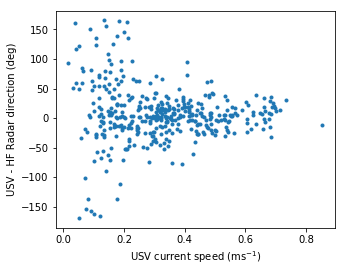

In [55]:
fig, ax = plt.subplots(figsize=(5,4))
ax.plot(usv_spd,dif_dir,'.')
ax.set_xlabel('USV current speed (ms$^{-1}$)')
ax.set_ylabel('USV - HF Radar direction (deg)')
fig_fname='F:/data/cruise_data/saildrone/baja-2018/figs/hf_radar_wdir_wspd_both_bias.png'
fig.savefig(fig_fname, transparent=False, format='png')


0.49021618580725085 0.11672924725563835 0.6728684322696414 2.5601207640287757e-54 0.02694757054609088


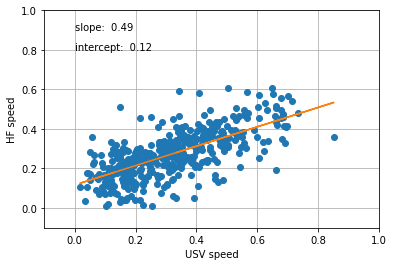

In [67]:

# Learn about API authentication here: https://plot.ly/python/getting-started
# Find your api_key here: https://plot.ly/settings/api
# MatPlotlib
import matplotlib.pyplot as plt
from matplotlib import pylab
# Scientific libraries
from numpy import arange,array,ones
from scipy import stats

usv_spd = ds_new.spd
sat_spd = ds_collocated_averaged.spd
usv_dir = ds_new.dir
sat_dir = ds_collocated_averaged.dir
dif_spd,dif_dir = usv_spd - sat_spd, usv_dir - sat_dir
cond,cond2 = (dif_dir > 180),(dif_dir < -180)
cond,cond2 = (dif_dir > 180),(dif_dir < -180)
dif_dir[cond]-=360
dif_dir[cond2]+=360

usv_ucur = ds_new.u_usv
usv_vcur = ds_new.v_usv
sat_ucur = ds_collocated_averaged.u
sat_vcur = ds_collocated_averaged.v
usv_spd  = np.sqrt(usv_ucur**2 + usv_vcur**2)
sat_spd  = np.sqrt(sat_ucur**2 + sat_vcur**2)

cond = (np.isfinite(usv_spd) & np.isfinite(sat_spd))
usv_spd = usv_spd[cond]
sat_spd = sat_spd[cond]
usv_dir = usv_dir[cond]
sat_dir = sat_dir[cond]

xi = usv_spd.data
A = array([ xi, ones(sat_spd.shape[0])])
y = sat_spd.data
# Generated linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(xi,y)
line = slope*xi+intercept
plt.plot(xi,y,'o', xi, line)
plt.ylim(-.1,1),plt.xlim(-.1,1)
plt.grid()
plt.xlabel('USV speed')
plt.ylabel('HF speed')
print(slope,intercept,r_value,p_value,std_err)
plt.text(0,.9,"slope: {0} {1:.2f}".format("", slope))
plt.text(0,.8,"intercept: {0} {1:.2f}".format("", intercept))
fig_fname='F:/data/cruise_data/saildrone/baja-2018/figs/hf_radar_usv_big_spd.png'
plt.savefig(fig_fname, transparent=False, format='png')

#pylab.title('Linear Fit with Matplotlib')
#ax = plt.gca()
#ax.set_axis_bgcolor((0.898, 0.898, 0.898))
#fig = plt.gcf()
#py.plot_mpl(fig, filename='linear-Fit-with-matplotlib')


0.46009187384406464 -0.014077257105056867 0.6409206876479294 5.903803042888306e-47 0.02783147521944993
0.5418091916711263 -0.09741792256662488 0.7213941581201176 1.5720413187847492e-64 0.02627035766046832
0.5009490945301331 0.11486823150299047 0.6843328232819383 9.93912907032723e-56 0.026959501683771214


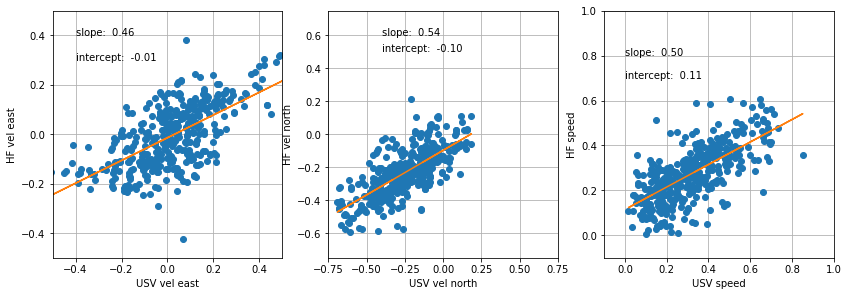

In [73]:
f, axes = plt.subplots(1,3,figsize=(14,10))
usv_ucur = ds_new.u_usv
usv_vcur = ds_new.v_usv
sat_ucur = ds_collocated_averaged.u
sat_vcur = ds_collocated_averaged.v
usv_spd  = np.sqrt(usv_ucur**2 + usv_vcur**2)
sat_spd  = np.sqrt(sat_ucur**2 + sat_vcur**2)

cond = (np.isfinite(usv_ucur) & np.isfinite(sat_ucur) & ( usv_vcur<.2))
usv_ucur = usv_ucur[cond]
sat_ucur = sat_ucur[cond]
usv_vcur = usv_vcur[cond]
sat_vcur = sat_vcur[cond]
usv_spd = usv_spd[cond]
sat_spd = sat_spd[cond]

xi = usv_ucur.data
A = array([ xi, ones(usv_ucur.shape[0])])
y = sat_ucur.data
# Generated linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(xi,y)
line = slope*xi+intercept
plt.subplot(231)
plt.plot(xi,y,'o', xi, line)
plt.ylim(-.5,.5),plt.xlim(-.5,.5)
plt.grid()
plt.xlabel('USV vel east')
plt.ylabel('HF vel east')
print(slope,intercept,r_value,p_value,std_err)
plt.text(-.4,.4,"slope: {0} {1:.2f}".format("", slope))
plt.text(-.4,.3,"intercept: {0} {1:.2f}".format("", intercept))
xi = usv_vcur.data
A = array([ xi, ones(usv_vcur.shape[0])])
y = sat_vcur.data
# Generated linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(xi,y)
line = slope*xi+intercept
plt.subplot(232)
plt.plot(xi,y,'o', xi, line)
plt.ylim(-.75,.75),plt.xlim(-.75,.75)
plt.grid()
plt.xlabel('USV vel north')
plt.ylabel('HF vel north')
print(slope,intercept,r_value,p_value,std_err)
plt.text(-.4,.6,"slope: {0} {1:.2f}".format("", slope))
plt.text(-.4,.5,"intercept: {0} {1:.2f}".format("", intercept))
xi = usv_spd
A = array([ xi, ones(usv_spd.shape[0])])
y = sat_spd
# Generated linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(xi,y)
line = slope*xi+intercept
plt.subplot(233)
plt.plot(xi,y,'o', xi, line)
plt.ylim(-.1,1),plt.xlim(-.1,1)
plt.grid()
plt.xlabel('USV speed')
plt.ylabel('HF speed')
print(slope,intercept,r_value,p_value,std_err)
plt.text(-.0,.8,"slope: {0} {1:.2f}".format("", slope))
plt.text(-.0,.7,"intercept: {0} {1:.2f}".format("", intercept))
fig_fname='F:/data/cruise_data/saildrone/baja-2018/figs/hf_radar_usv_u_v_spd.png'
plt.savefig(fig_fname, transparent=False, format='png')


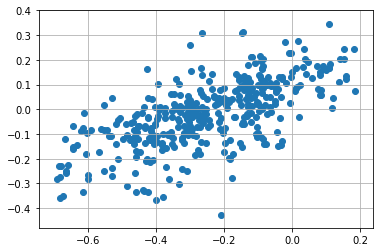

In [25]:
plt.scatter(usv_vcur,usv_vcur-sat_vcur)
plt.grid()

In [26]:
#more plotting stuff below
#may not work with opendap file ratehr than collocated data file

#try to use 1km data just for a day
#hf_filename = 'http://hfrnet-tds.ucsd.edu/thredds/dodsC/HFR/USWC/2km/hourly/RTV/HFRADAR_US_West_Coast_2km_Resolution_Hourly_RTV_best.ncd'
hf_filename = 'http://hfrnet-tds.ucsd.edu/thredds/dodsC/HFR/USWC/6km/hourly/RTV/HFRADAR_US_West_Coast_6km_Resolution_Hourly_RTV_best.ncd'
ds_sat = xr.open_dataset(hf_filename)
subset = ds_sat.sel(lon=slice(ds_usv_subset.lon.min().data,ds_usv_subset.lon.max().data),
                    lat=slice(32,33),
                   time=slice('2018-04-20T01','2018-04-22T22'))
#subset = ds_sat.sel(lon=slice(ds_usv_subset.lon.min().data,ds_usv_subset.lon.max().data),
#                    lat=slice(ds_usv_subset.lat.min().data,ds_usv_subset.lat.max().data),
#                   time=slice('2018-04-20T01','2018-04-22T22'))
subset.load()  #this loads data into memory instead of leaving it lazy.  the hf radar opendap need this for some reason
subset['spd']=np.sqrt(subset.u**2+subset.v**2)
subset['dir']=np.arctan2(subset.v,subset.u)*180/np.pi

In [27]:
#now collocate with usv lat and lons
ds_collocated = subset.interp(lat=ds_usv_subset.lat,lon=ds_usv_subset.lon,time=ds_usv_subset.time,method='linear')
ds_collocated_nearest = subset.interp(lat=ds_usv_subset.lat,lon=ds_usv_subset.lon,time=ds_usv_subset.time,method='nearest')

AttributeError: 'Dataset' object has no attribute 'UWND_MEAN'

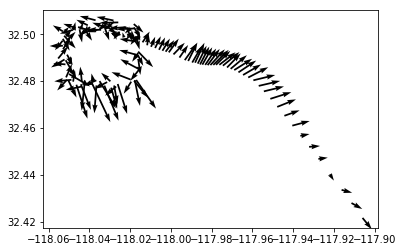

In [28]:
usv1 = ds_usv_subset.sel(time=slice('2018-04-20T01','2018-04-20T22'))
hf1 = ds_collocated_nearest.sel(time=slice('2018-04-20T01','2018-04-20T22'))
#print(usv1.lat)
ax1=plt.subplot(1,1,1)
ax1.quiver(usv1.lon,usv1.lat,usv1.vel_east,usv1.vel_north)
ax1.quiver(usv1.lon,usv1.lat,usv1.UWND_MEAN,usv1.VWND_MEAN,color='b')
ax1.quiver(hf1.lon,hf1.lat,hf1.u,hf1.v,color='r')
fig_fname='F:/data/cruise_data/saildrone/baja-2018/figs/hf_radar_tseries_420_1kmboth_bias.png'
plt.savefig(fig_fname, transparent=False, format='png')


In [ ]:
subset.spd[0,:,:].plot()
plt.plot(usv1.lon,usv1.lat,'r.')

In [ ]:
hf1

In [ ]:
ds_usv2['spd']=np.sqrt(ds_usv2.vel_east**2+ds_usv2.vel_north**2)
for i in range(1,8000,50):
    plt.plot(ds_usv2.spd[i,0:20]-ds_usv2.spd[i,20],ds_usv2.cell_depth[0:20])



In [ ]:
plt.plot(np.sqrt(ds_usv2.UWND_MEAN**2+ds_usv2.VWND_MEAN**2),ds_usv2.spd[:,0],'.')

In [ ]:
usv1 = ds_usv_subset.sel(time=slice('2018-04-20T13','2018-04-20T15'))
#usv2 = usv1.where(usv1.ROLL>10)
usv1['droll']=usv1.ROLL.diff(dim='time')
usv2 = usv1.where(np.abs(usv1.droll>1))
#hf1 = ds_collocated_nearest.sel(time=slice('2018-04-20T00','2018-04-20T22'))
#print(usv1.lat)
ax1=plt.subplot(1,1,1)
ax1.quiver(usv1.lon,usv1.lat,usv1.vel_east,usv1.vel_north)
ax1.quiver(usv2.lon,usv2.lat,usv2.vel_east,usv2.vel_north,color='r')
#ax1.quiver(usv1.lon.where(usv1.ROLL>15),usv1.lat.where(usv1.ROLL>15),usv1.vel_east.where(usv1.ROLL>15),usv1.vel_north.where(usv1.ROLL>15),'r')
#ax1.quiver(usv1.lon,usv1.lat,usv1.UWND_MEAN,usv1.VWND_MEAN,color='b')
#ax1.quiver(hf1.lon,hf1.lat,hf1.u,hf1.v,color='r')
fig_fname='F:/data/cruise_data/saildrone/baja-2018/figs/hf_radar_tseries_420both_bias.png'
plt.savefig(fig_fname, transparent=False, format='png')
#usv2#the direction is turning as it moves around grid, in 12 hours it rotates almost 180 degrees
usv1 = ds_usv_subset.sel(time=slice('2018-04-20T05','2018-04-20T15'))
hf1 = ds_collocated_nearest.sel(time=slice('2018-04-20T00','2018-04-20T22'))
#print(usv1.lat)
ax1=plt.subplot(1,1,1)
#usv1.roll
#usv1['droll']=usv1.ROLL[:-1]-usv1.ROLL[1:]
#usv1['droll']=usv1.ROLL.diff(dim='time')
#ax1.plot(usv1.ROLL.diff(dim='time'),'r')
#ax1.plot(usv1.ROLL,'b')
usv1['dir2']=usv1.dir.copy(deep=True)
usv1['dir2'] = np.mod(usv1['dir2'],360)
ax1.plot(usv1.time.dt.hour,usv1.dir2,'g.')
#ax1.plot(usv1.ROLL.where(usv1.ROLL>15),'r')
#ax1.quiver(usv1.lon,usv1.lat,usv1.UWND_MEAN,usv1.VWND_MEAN,color='b')
#ax1.quiver(hf1.lon,hf1.lat,hf1.u,hf1.v,color='r')
#fig_fname='F:/data/cruise_data/saildrone/baja-2018/figs/hf_radar_tseries_420both_bias.png'
#plt.savefig(fig_fname, transparent=False, format='png')

